### Решение 2D уравнения теплопроводности через явную и неявную схему с помощью метода сопряжённых градиентов

#### Метод сопряжённых градиентов

##### 1. Постановка задачи

Необходимо реализовать метод решения СЛАУ с симметричной положительно определённой матрицей.

$Ax = b$

$A = A^T > 0$

Проанализировать требуемое количество итераций в зависимости от числа обусловленности матрицы и сравнить реализованный метод с пакетными методами Numpy. 

##### 2. Описание метода

Метод сопряженных градиентов — численный метод решения систем линейных алгебраических уравнений, является итерационным методом.

Основная идея в том, что вводятся сопряжёные векторы $S_1,...,S_n$ такие, что:

$S_i^T H S_j = 0, ~~~~ i \neq j, ~~~~ i, j = 1,...,n$

$S_i^T H S_i \geq 0, ~~~~ i = 1,...,n$

Начальное приближение: $x_0$

Невязка: $r_0 = b - Ax$

Первое направление: $p_0 = r_0$

k-я итерация метода:

$\alpha_k = \dfrac{r_k^T r_k}{p_k^T A p_k}$

$x_{k+1} x_k + \alpha_k p_k$

$r_{k+1} = r_k - \alpha_k A p_k$

$\beta_k = \dfrac{r_{k+1}^T r_{k+1}}{r_k^T r_k} ~~~~ (формула Флетчера-Ривса)$ 

$p_{k+1} = r_{k+1} + \beta_k p_k$

Особенность метода в ортогональности невязок, из-за чего направления минимизации не повторяются, и метод сходится за n шагов. Параллелизовать в данном методе можно параллелизовать матрично-векторное умножение и скалярное произведение, также можно комбинировать его с другими методами (например, скорейшего спуска на начальных итерациях). Также стоит отметить возможность предобуславливания матрицы, что значительно ускоряет вычисления, но сама операция предобуславливания может быть дорогостоящей.  


Данный метод работает только для симметричных положительно определённых матриц. Погрешность метода совпадает с погрешность представления вещественных чисел (на современных машинах $\varepsilon \approx 10^{-15}$). На практике точность оценивается по относительной невязке.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import time

def conjugate_gradient(A, b, x0=None, max_iter=1000, tol=1e-6):
    if x0 is None:
        x0 = np.zeros_like(b)
    x = x0.copy()
    r = b - A @ x
    p = r.copy()
    residuals = [np.linalg.norm(r)]
    for _ in range(max_iter):
        Ap = A @ p
        alpha = (r.T @ r) / (p.T @ Ap)
        x += alpha * p
        r_new = r - alpha * Ap
        beta = (r_new.T @ r_new) / (r.T @ r)
        p = r_new + beta * p
        r = r_new
        residuals.append(np.linalg.norm(r))
        if residuals[-1] < tol:
            break
    return x, residuals

def simple_iteration(A, b, x0=None, max_iter=1000, tol=1e-6, alpha=0.1):
    if x0 is None:
        x0 = np.zeros_like(b)
    x = x0.copy()
    residuals = []
    for _ in range(max_iter):
        r = b - A @ x
        residuals.append(np.linalg.norm(r))
        if residuals[-1] < tol:
            break
        x += alpha * r  # Упрощённый выбор параметра для демонстрации
    return x, residuals

def generate_spd_matrix(n, kappa=100):
    U = np.random.randn(n, n)
    U, _ = np.linalg.qr(U)
    s = np.logspace(0, np.log10(kappa), n)
    return U @ np.diag(s) @ U.T

In [7]:
# Параметры тестирования
sizes = [i for i in range(100, 7000, 250)]
kappa = 100  # Число обусловленности
results = {
    'CG': {'time': [], 'iters': []},
    'MPI': {'time': [], 'iters': []},
    'solve': {'time': []}
}

for n in sizes:
    A = generate_spd_matrix(n, kappa)
    b = np.random.randn(n)
    
    # Тестирование CG
    start = time.time()
    x_cg, res_cg = conjugate_gradient(A, b, tol=1e-6)
    results['CG']['time'].append(time.time() - start)
    results['CG']['iters'].append(len(res_cg))
    
    # Тестирование МПИ
    start = time.time()
    x_mpi, res_mpi = simple_iteration(A, b, alpha=0.01, tol=1e-6)
    results['MPI']['time'].append(time.time() - start)
    results['MPI']['iters'].append(len(res_mpi))
    
    # Тестирование solve
    start = time.time()
    np.linalg.solve(A, b)
    results['solve']['time'].append(time.time() - start)

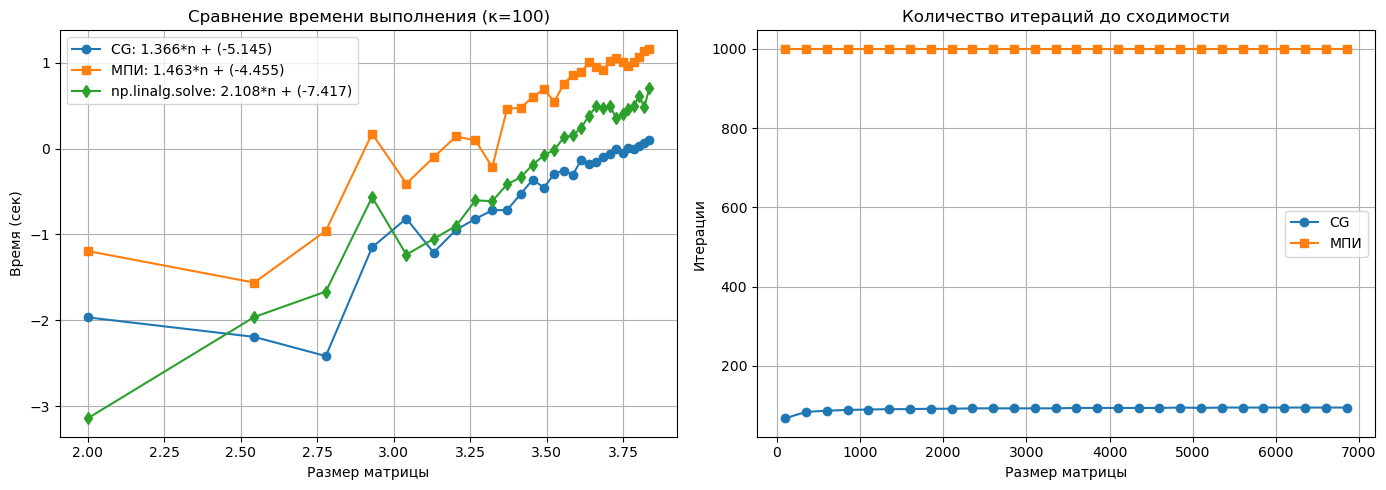

In [16]:
# Визуализация
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

cg = np.polyfit(np.log10(sizes)[10:], np.log10(results['CG']['time'])[10:], 1)
mpi = np.polyfit(np.log10(sizes)[10:], np.log10(results['MPI']['time'])[10:], 1)
linalg = np.polyfit(np.log10(sizes)[10:], np.log10(results['solve']['time'])[10:], 1)

# График времени выполнения
ax1.plot(np.log10(sizes), np.log10(results['CG']['time']), 'o-', label=f"CG: {cg[0]:.3f}*n + ({cg[1]:.3f})")
ax1.plot(np.log10(sizes), np.log10(results['MPI']['time']), 's-', label=f'МПИ: {mpi[0]:.3f}*n + ({mpi[1]:.3f})')
ax1.plot(np.log10(sizes), np.log10(results['solve']['time']), 'd-', label=f'np.linalg.solve: {linalg[0]:.3f}*n + ({linalg[1]:.3f})')
ax1.set_xlabel('Размер матрицы')
ax1.set_ylabel('Время (сек)')
ax1.set_title('Сравнение времени выполнения (κ=100)')
ax1.legend()
ax1.grid(True)

# График количества итераций
ax2.plot(sizes, results['CG']['iters'], 'o-', label='CG')
ax2.plot(sizes, results['MPI']['iters'], 's-', label='МПИ')
ax2.set_xlabel('Размер матрицы')
ax2.set_ylabel('Итерации')
ax2.set_title('Количество итераций до сходимости')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [28]:
# Параметры тестирования
matrix_size = 1000
kap = [i for i in range(1000, 40000, 400)]
time_to_kappa = []

for j in kap:
    A = generate_spd_matrix(matrix_size, j)
    b = np.random.randn(matrix_size)

    start = time.time()
    x_cg, res_cg = conjugate_gradient(A, b, tol=1e-6)
    time_to_kappa.append(time.time() - start)

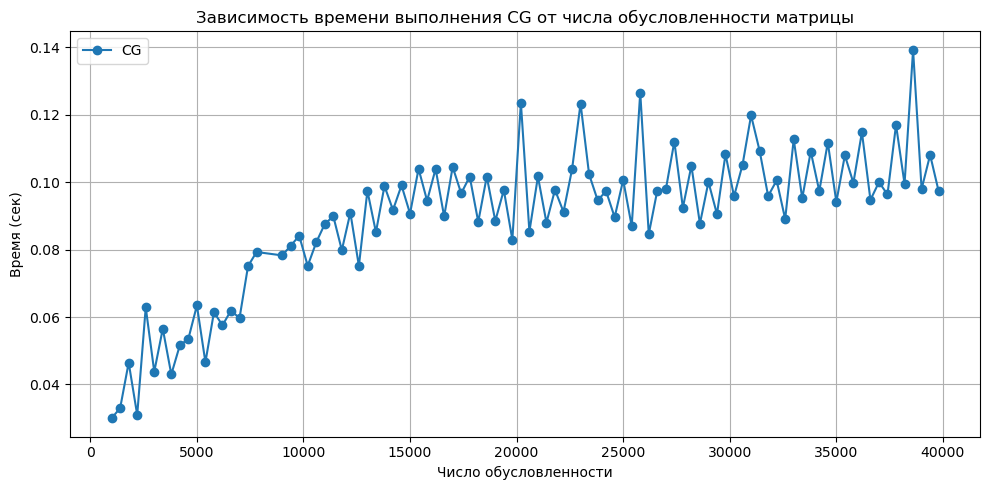

In [32]:
# Визуализация
fig, ax1 = plt.subplots(1, figsize=(10, 5))

# График времени выполнения
ax1.plot(kap, time_to_kappa, 'o-', label="CG")
ax1.set_xlabel('Число обусловленности')
ax1.set_ylabel('Время (сек)')
ax1.set_title('Зависимость времени выполнения CG от числа обусловленности матрицы')
ax1.legend()
ax1.grid(True)

plt.tight_layout()
plt.show()